# Height-dependent radar sensitivity threshold

Define Ze threshold for cloud mask based on Ze vs range histogram for all radar
observations.

In [2]:
import sys

sys.path.append("../")

In [42]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
from dask.diagnostics import ProgressBar
from xhistogram.xarray import histogram

from cloudtypes import ze_threshold
from readers.radar import read_radar_multiple

ProgressBar().register()

Read entire radar dataset

In [4]:
ds = read_radar_multiple()

Define Ze and height bin edges for histogram

In [11]:
height_bins = ds.height.values

# define edges between height bins
height_step = height_bins[1] - height_bins[0]  # assumes constant height
height_bin_edges = 0.5 * (height_bins[1:] + height_bins[:-1])
height_bin_edges = np.append(
    height_bin_edges, np.array([height_bin_edges[-1] + height_step])
)
height_bin_edges = np.append(
    np.array([height_bin_edges[0] - height_step]), height_bin_edges
)

In [12]:
# ze bin edges
ze_bin_edges = np.arange(-100, 50.2, 0.2)

Compute histogram

In [37]:
# compute histogram
ds_flat = ds.radar_reflectivity.stack({"x": ("time", "height")})
da_cfad = histogram(
    ds_flat,
    ds_flat.height,
    bins=[ze_bin_edges, height_bin_edges],
    dim=["x"],
)
da_cfad = da_cfad.compute()

[########################################] | 100% Completed | 249.02 s
[########################################] | 100% Completed | 249.04 s


Show CFAD together with cloud detection threshold

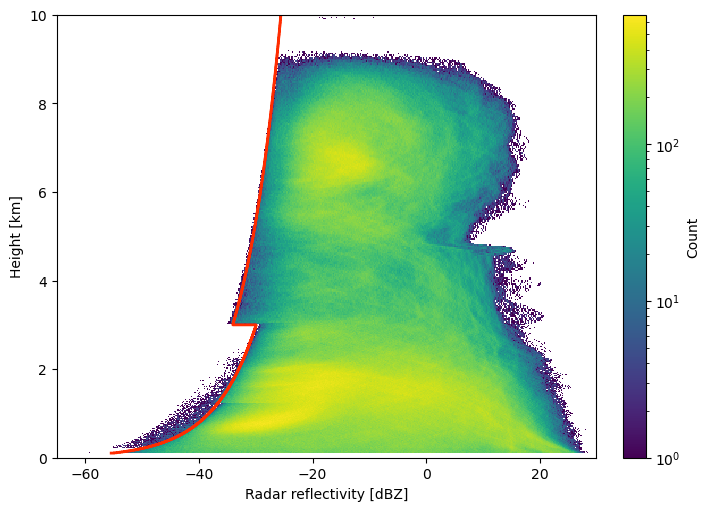

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5), constrained_layout=True)

hist = da_cfad.values.copy().astype("float")
hist[hist == 0] = np.nan
im = ax.pcolormesh(
    da_cfad.radar_reflectivity_bin,
    da_cfad.height_bin * 1e-3,
    hist.T,
    shading="nearest",
    norm=mcolors.LogNorm(vmin=1),
)
fig.colorbar(im, label="Count")

# plot sensitivity thresholds
ax.step(
    ze_threshold(ds.height),
    ds.height * 1e-3,
    color="#FF2C00",
    where="post",
    linewidth=2,
)

ax.set_xlim(-65, 30)
ax.set_ylim(0, 10)
ax.set_ylabel("Height [km]")
ax.set_xlabel("Radar reflectivity [dBZ]")

plt.show()